In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as A
torch.manual_seed(7)
import pandas as pd

from sklearn.manifold import TSNE


import sklearn.manifold 
from matplotlib import pyplot as plt

In [2]:
corpus_filename = '//data/emojis.txt' 

In [3]:
corpus = open(corpus_filename).read().splitlines()

In [4]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

In [5]:
def onlyEmojiSequences(tokens):
    threshold_emojis = [x for x in tokens if len(x) > 1]
    return threshold_emojis

In [6]:
tokenized_corpus = tokenize_corpus(corpus)
emojiSequences = onlyEmojiSequences(tokenized_corpus)

In [7]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

# this is just the very basic translation both ways plus the length of vocabulary

In [8]:
window_size = 2
idx_pairs = []
# for each sentence
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    # for each word, threated as center word
    for center_word_pos in range(len(indices)):
        # for each window position
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs) # it will be useful to have this as numpy array

# sole purpose of this is to have pairs! of target and context word
# super simple once you have figured out the code!

In [9]:
def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x

# this is a one hot encoded something

In [10]:
torch.manual_seed(7)
torch.cuda.manual_seed_all

dtype = torch.float 
dimensionSize = 300
num_epochs = 5
learning_rate = 0.001


firstLayer = torch.randn(dimensionSize, vocabulary_size, requires_grad=True).float()
secondLayer = torch.randn(vocabulary_size, dimensionSize, requires_grad=True).float()


for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:


        # one hot encoded tensor
        x = get_input_layer(data).float()
        # target word 
        y_true = torch.from_numpy(np.array([target])).long()

        # Hidden Layer: gradient magic happening ...
        z1 = torch.matmul(firstLayer, x)
        z2 = torch.matmul(secondLayer, z1)

        # introducing non-linearity
        softmax = A.LogSoftmax(dim=0)
        soft_max_output = softmax(z2)

        # neg_log_likelihood
        loss = F.nll_loss(soft_max_output.view(1,-1), y_true)
        loss_val += loss  # this might be to please the  framework, and adding stuff to the gradient calculator
        
        # propagating it back
        loss.backward()
        
        # updating the weights of both layers
        firstLayer.data -= learning_rate * firstLayer.grad.data
        secondLayer.data -= learning_rate * secondLayer.grad.data

        # set the gradients to zero for next iteration
        firstLayer.grad.data.zero_()
        secondLayer.grad.data.zero_()
        
    # this keeps track of the loss, hopefully it does converge
    if epo % 1000 == 0:    
        print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')



Loss at epo 0: 13.046099662780762


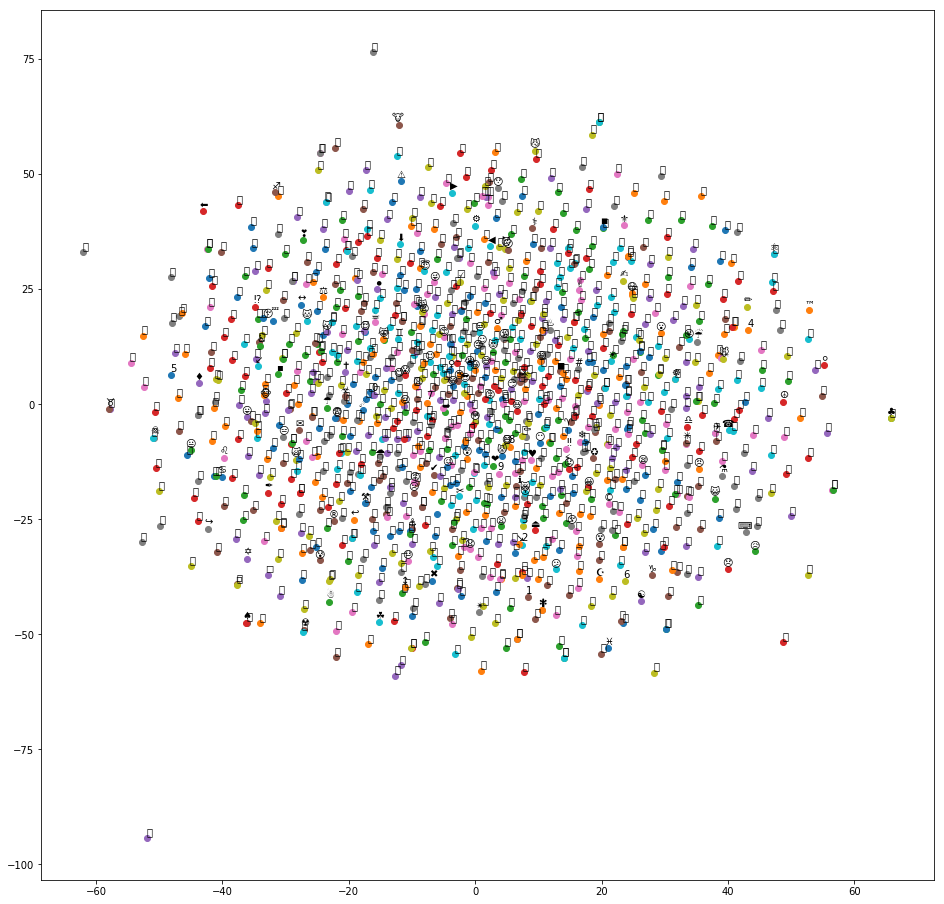

In [11]:
"Creates and TSNE model and plots it"
tokens = []

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)

new_values = tsne_model.fit_transform(secondLayer.detach().numpy())

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(vocabulary[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')